In [ ]:
path1 = "Spectronaut_5007.tsv"; path2 = "Spectronaut_4994.tsv"

In [4]:
###Achtung: if you didn't install the fowllowing tools in your virtualenv, do it here
###you just need to run this cell once to get the necessary tools from the very beginning
##%pip install numpy matplotlib pandas duckdb upsetplot

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pandas as pd

import duckdb

#get re
import re

#venn diagram
import upsetplot
import warnings

from datetime import datetime

# In-Depth Proteomics Analysis for R&D team

## Datasets

Here, we will do proteomics evaluation based on two Spectronaut datasets:

In [4]:
print(f"1. {path1}\n2. {path2}")

1. Spectronaut_5007.tsv
2. Spectronaut_4994.tsv


In [5]:
##read the .tsv tables
pd.set_option("display.max_columns", None)
tsvfile1 = pd.read_csv(path1, index_col=0, sep="\t")
tsvfile2 = pd.read_csv(path2, index_col=0, sep="\t")
tsvfile1.columns = [c.replace(".","_") for c in tsvfile1.columns]
tsvfile2.columns = [c.replace(".","_") for c in tsvfile2.columns]

In [6]:
#write the multiple entrances in multiple rows
def yaniterator(X):
    for index, *_tuple in X.itertuples(name=None):
        for untupled_tuple in zip(*(_str.split(";") for _str in _tuple)):
            yield (index,) + untupled_tuple

def get_table(tsvdata):
    selected_col = ["PG_ProteinLabel", "PG_Genes", "PG_ProteinAccessions", "PG_ProteinNames"]
    X = tsvdata[selected_col]
    Y = pd.DataFrame(yaniterator(X), columns=["X_index"] + list(X.columns)).set_index("X_index")
    return pd.concat([Y,tsvdata.drop(columns=selected_col).loc[Y.index]],axis=1)

data1 = get_table(tsvfile1).reset_index().drop(columns=["X_index"])
data2 = get_table(tsvfile2).reset_index().drop(columns=["X_index"])

In [7]:
#first dataset: rename
data1["run"]=data1["R_FileName"].str[:4]
data1["species"]=data1["PG_ProteinNames"].str[-5:]
data1=data1.rename({'PEP_StrippedSequence':'stripped_peptides','PG_ProteinAccessions':'ProteinID',
                    'FG_Charge':'charge','FG_TheoreticalMz':'mz','EG_ApexRT':'rt','FG_IntMID':'modified_peptides',
                    'FG_MS1Quantity':'ms1_intensity','FG_Id':'precursors','R_Replicate':'replicate',
                    'R_Condition':'condition','EG_IonMobility':'ion_mobility'}, axis='columns')

#second dataset: rename
data2["run"]=data2["R_FileName"].str[:4]
data2["species"]=data2["PG_ProteinNames"].str[-5:]
data2=data2.rename({'PEP_StrippedSequence':'stripped_peptides','PG_ProteinAccessions':'ProteinID',
                    'FG_Charge':'charge','FG_TheoreticalMz':'mz','EG_ApexRT':'rt','FG_IntMID':'modified_peptides',
                    'FG_MS1Quantity':'ms1_intensity','FG_Id':'precursors','R_Replicate':'replicate',
                    'R_Condition':'condition','EG_IonMobility':'ion_mobility'}, axis='columns')


In [8]:
#select the useful columns
#data1["pep_len"]=data1["stripped_peptides"].str.len()
table1 = (
    data1.groupby(["run","ProteinID","species","stripped_peptides","modified_peptides","charge","mz"])[["ms1_intensity","rt","ion_mobility"]].mean()
    .reset_index()
)
table2 = (
    data2.groupby(["run","ProteinID","species","stripped_peptides","modified_peptides","charge","mz"])[["ms1_intensity","rt","ion_mobility"]].mean()
    .reset_index()
)

## Number of IDs:
* Protein Groups
* stripped peptides

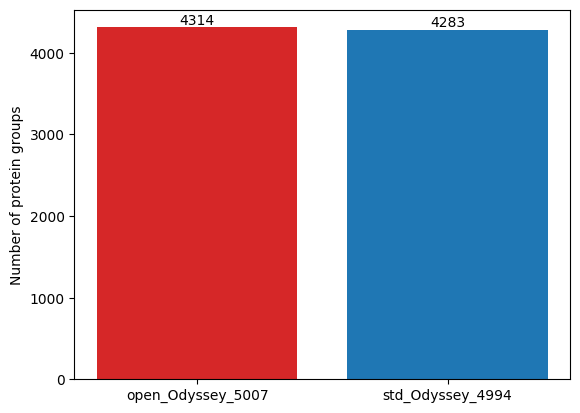

In [9]:
fig, ax = plt.subplots()

species = ("open_Odyssey_5007","std_Odyssey_4994")
counts = [len(table1.drop_duplicates(subset='ProteinID', keep="first")), 
          len(table2.drop_duplicates(subset='ProteinID', keep="first"))]
bar_labels = ['red', 'blue']
bar_colors = ['tab:red', 'tab:blue']

#ax.bar(species, counts, label=bar_labels, color=bar_colors)
ax.bar(species, counts, color=bar_colors)

ax.set_ylabel('Number of protein groups')
ax.bar_label(ax.containers[0], label_type='edge')
#ax.set_title('')
#ax.set_xticks(x + width, species)
#ax.legend(loc='upper left', ncols=3)
#ax.set_ylim(0, 5400)
#plt.savefig('protein.png', format="png",bbox_inches='tight')
plt.show()

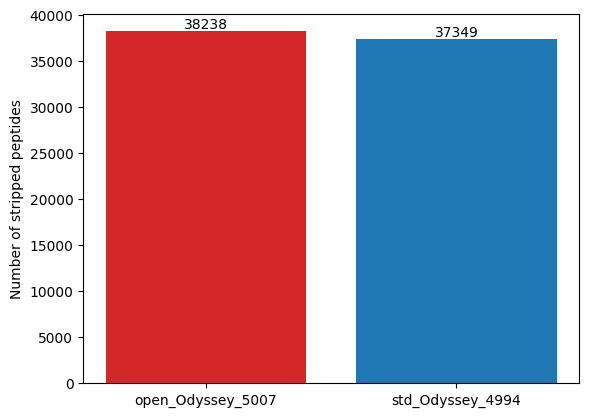

In [10]:
fig, ax = plt.subplots()

species = ("open_Odyssey_5007","std_Odyssey_4994")
counts = [len(table1.drop_duplicates(subset='stripped_peptides', keep="first")), 
          len(table2.drop_duplicates(subset='stripped_peptides', keep="first"))]
bar_labels = ['red', 'blue', 'green', 'm']
bar_colors = ['tab:red', 'tab:blue', 'tab:green','m']

ax.bar(species, counts, color=bar_colors)

ax.set_ylabel('Number of stripped peptides')
ax.bar_label(ax.containers[0], label_type='edge')

plt.show()

In [11]:
print(f"""The above figures shown that, \
{len(table1.drop_duplicates(subset='ProteinID', keep="first"))} and {len(table2.drop_duplicates(subset='ProteinID', keep="first"))} protein groups, \
{len(table1.drop_duplicates(subset='stripped_peptides', keep="first"))} and {len(table2.drop_duplicates(subset='stripped_peptides', keep="first"))} \
stripped peptides are found in the two datasets, respectively.
""")

The above figures shown that, 4314 and 4283 protein groups, 38238 and 37349 stripped peptides are found in the two datasets, respectively.



## Venn Diagram of proteins and peptides

This will show us, how many proteins and stripped peptides in the two datasets are in common.

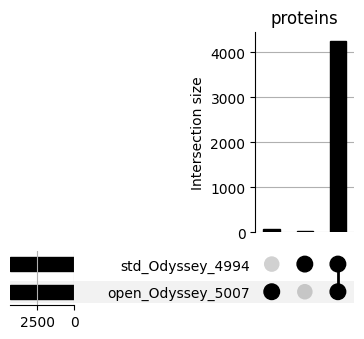

In [12]:
#prepare the venn diagram for progein groups
#get the peptide sequences (no duplicates) for all compared tools:
PEP_table1 = pd.DataFrame(table1["ProteinID"],columns=['ProteinID']).drop_duplicates(subset='ProteinID', keep="first")
PEP_table2 = pd.DataFrame(table2["ProteinID"],columns=['ProteinID']).drop_duplicates(subset='ProteinID', keep="first")

PEP_table1["open_Odyssey_5007"]='True'
PEP_table2["std_Odyssey_4994"]='True'

#join the tables
PEP_table1.set_index('ProteinID',inplace=True)
PEP_table2.set_index('ProteinID',inplace=True)

final_PEP = pd.concat([PEP_table1,PEP_table2],axis=1,sort=False).reset_index()

#replace all NaN with False
final_PEP["open_Odyssey_5007"].fillna(False,inplace=True)
final_PEP["std_Odyssey_4994"].fillna(False,inplace=True)
#change the dtypes to boolean
for c in ["open_Odyssey_5007","std_Odyssey_4994"]:
    final_PEP[c] = final_PEP[c].astype(bool)
final_PEP.dtypes

#plot venn diagram
PEP_upsetplot = final_PEP.groupby(["open_Odyssey_5007","std_Odyssey_4994"]).ProteinID.size()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pg_min=PEP_upsetplot[2]/max(len(PEP_table1),len(PEP_table2))
    upsetplot.plot(PEP_upsetplot)

#plt.savefig('vennd.png', format="png",bbox_inches='tight')
plt.title("proteins")
plt.show()

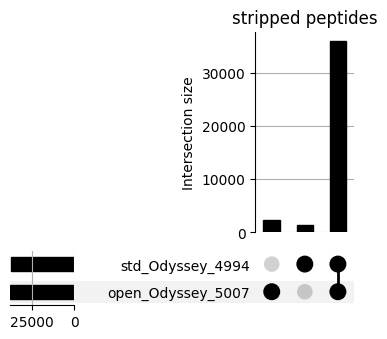

In [13]:
#get the peptide sequences (no duplicates) for all compared tools:
PEP_table1 = pd.DataFrame(table1["stripped_peptides"],columns=['stripped_peptides']).drop_duplicates(subset='stripped_peptides', keep="first")
PEP_table2 = pd.DataFrame(table2["stripped_peptides"],columns=['stripped_peptides']).drop_duplicates(subset='stripped_peptides', keep="first")

PEP_table1["open_Odyssey_5007"]='True'
PEP_table2["std_Odyssey_4994"]='True'

#join the tables
PEP_table1.set_index('stripped_peptides',inplace=True)
PEP_table2.set_index('stripped_peptides',inplace=True)

final_PEP = pd.concat([PEP_table1,PEP_table2],axis=1,sort=False).reset_index()

#replace all NaN with False
final_PEP["open_Odyssey_5007"].fillna(False,inplace=True)
final_PEP["std_Odyssey_4994"].fillna(False,inplace=True)
#change the dtypes to boolean
for c in ["open_Odyssey_5007","std_Odyssey_4994"]:
    final_PEP[c] = final_PEP[c].astype(bool)
final_PEP.dtypes

#plot venn diagram
PEP_upsetplot = final_PEP.groupby(["open_Odyssey_5007","std_Odyssey_4994"]).stripped_peptides.size()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pep_min=PEP_upsetplot[2]/max(len(PEP_table1),len(PEP_table2))
    upsetplot.plot(PEP_upsetplot)

#plt.savefig('vennd.png', format="png",bbox_inches='tight')
plt.title("stripped peptides")
plt.show()

In [14]:
print(f"Clearly, more than {pg_min*100}% of protein groups and {pep_min*100}%  of stripped peptides in the two datasets are in common.")

Clearly, more than 98.47009735744089% of protein groups and 93.93012186829856%  of stripped peptides in the two datasets are in common.


## Quantitative proteomic analysis

In this section, we will compare:
* retention time
* ion mobility
* m/z
* charge

between the two datasets.

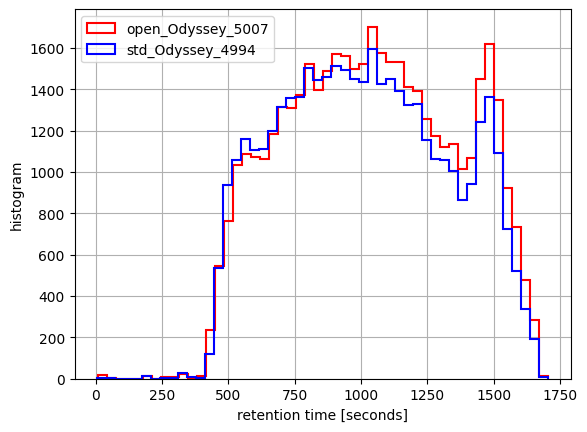

In [15]:
plt.xlabel('retention time [seconds]')
plt.ylabel('histogram')
plt.hist(table1["rt"]*60,bins=50,histtype='step',linewidth=1.5,color='r',label='open_Odyssey_5007')
plt.hist(table2["rt"]*60,bins=50,histtype='step',linewidth=1.5,color='b',label='std_Odyssey_4994')
plt.grid()

plt.legend()
plt.show()

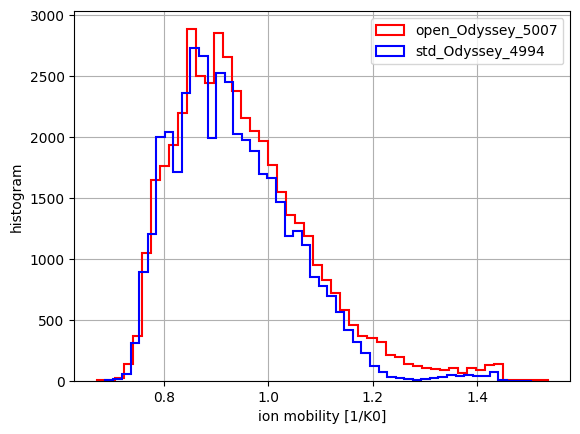

In [16]:
plt.xlabel('ion mobility [1/K0]')
plt.ylabel('histogram')
#plt.ylim([-6,4])
#plt.xlim([7,27])
#plt.xscale('log', basex=2)
plt.hist(table1["ion_mobility"],bins=50,histtype='step',linewidth=1.5,color='r',label='open_Odyssey_5007')
plt.hist(table2["ion_mobility"],bins=50,histtype='step',linewidth=1.5,color='b',label='std_Odyssey_4994')
plt.grid()
#plt.figure().set_figwidth(15)
#plt.savefig('IM.png', format="png",bbox_inches='tight')
plt.legend()
plt.show()

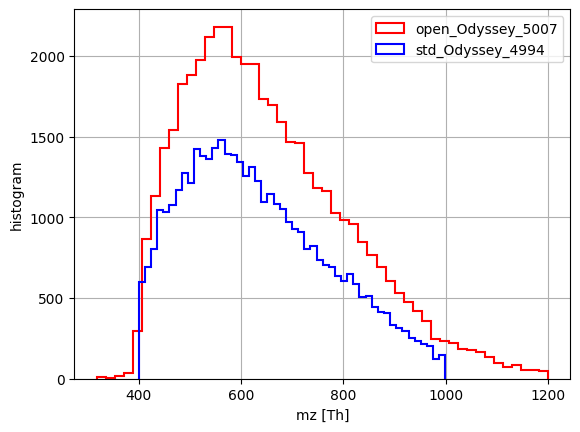

In [17]:
plt.xlabel('mz [Th]')
plt.ylabel('histogram')
plt.hist(table1["mz"],bins=50,histtype='step',linewidth=1.5,color='r',label='open_Odyssey_5007')
plt.hist(table2["mz"],bins=50,histtype='step',linewidth=1.5,color='b',label='std_Odyssey_4994')
plt.grid()

plt.legend()
plt.show()

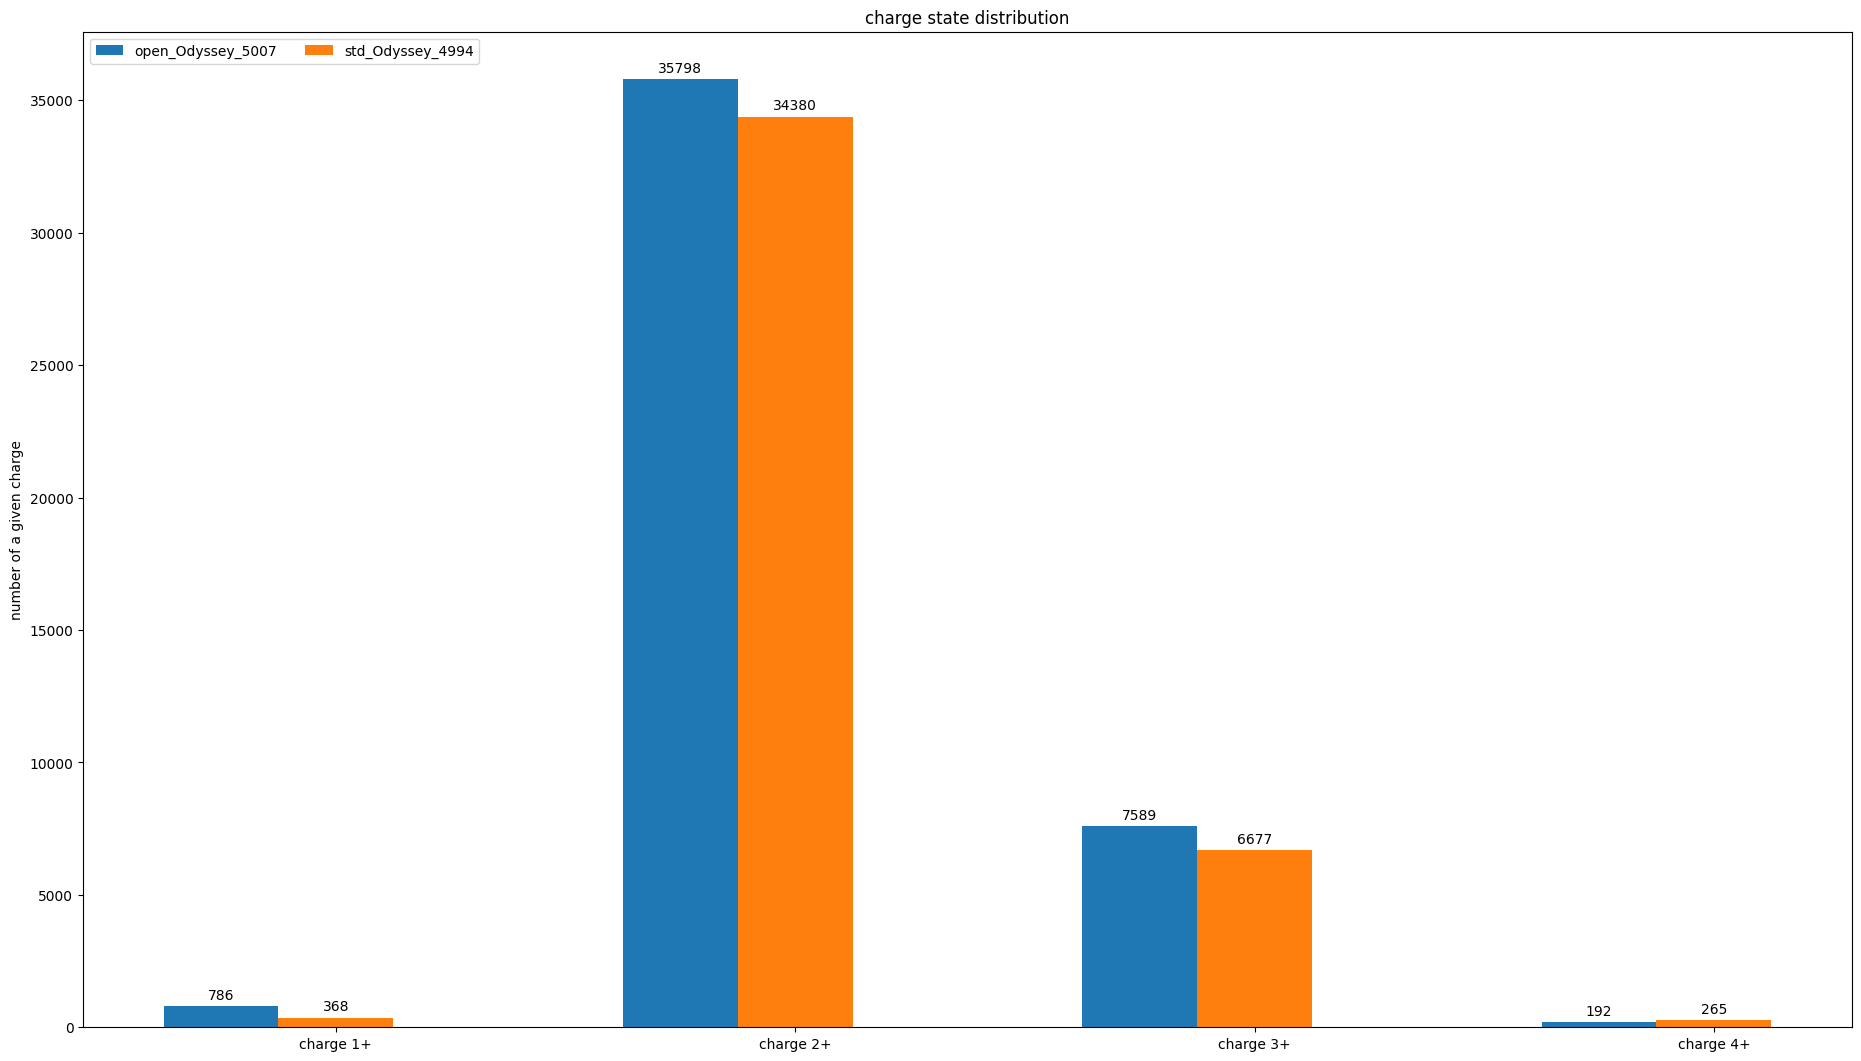

In [18]:
#charges
d1_charge1=table1["charge"].loc[table1["charge"]==1].count()
d1_charge2=table1["charge"].loc[table1["charge"]==2].count()
d1_charge3=table1["charge"].loc[table1["charge"]==3].count()
d1_charge4=table1["charge"].loc[table1["charge"]==4].count()
d2_charge1=table2["charge"].loc[table2["charge"]==1].count()
d2_charge2=table2["charge"].loc[table2["charge"]==2].count()
d2_charge3=table2["charge"].loc[table2["charge"]==3].count()
d2_charge4=table2["charge"].loc[table2["charge"]==4].count()

charges = ("charge 1+", "charge 2+", "charge 3+","charge 4+")
dataset = {
    'open_Odyssey_5007': (d1_charge1,d1_charge2,d1_charge3,d1_charge4),
    'std_Odyssey_4994': (d2_charge1,d2_charge2,d2_charge3,d2_charge4),
}

x = np.arange(len(charges))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

fig.set_size_inches(18.5,10.5,forward=True)

for attribute, measurement in dataset.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('number of a given charge')
ax.set_title('charge state distribution')
ax.set_xticks(x + width, charges)
ax.legend(loc='upper left', ncols=3)
#ax.set_ylim(0, 5400)

plt.show()

We have observe that, the histogram of ion mobility and retention time for the datasets under investigation is very similar to each other.

The m/z range in these datasets has noticeable difference.

The charge 2+ is the most popular charge state.

## What are the difference between the compared datasets?

To quantitatively characterize the differences between the datasets, we devide the stripped peptides in two sub-groups:
* peptides commonly detected in both datasets (common_pep)
* peptides which are separately detected in each dataset (diff_pep)

The properties like retention time, ion mobility, mz, peptide length, charge and MS1 intensity will be compared within these two sub-groups.

Note that, these properties should be similar to each other for common_pep. Our main focus is thus the diff_pep.

In [19]:
#get commonly found stripped peptides from the two tables:
PepInCommon = table1.merge(table2, left_on='stripped_peptides', right_on='stripped_peptides')
#get different stripped peptides in the two tables:
DiffInTable1 = table1.merge(table2, left_on='stripped_peptides', right_on='stripped_peptides',indicator = True, how='left').loc[lambda x : x['_merge']!='both']
DiffInTable2 = table2.merge(table1, left_on='stripped_peptides', right_on='stripped_peptides',indicator = True, how='left').loc[lambda x : x['_merge']!='both']
#drop unnecessary columns:
DiffInTable1 = DiffInTable1.drop(list(DiffInTable1.filter(regex='_y')),axis=1)
DiffInTable2 = DiffInTable2.drop(list(DiffInTable2.filter(regex='_y')),axis=1)

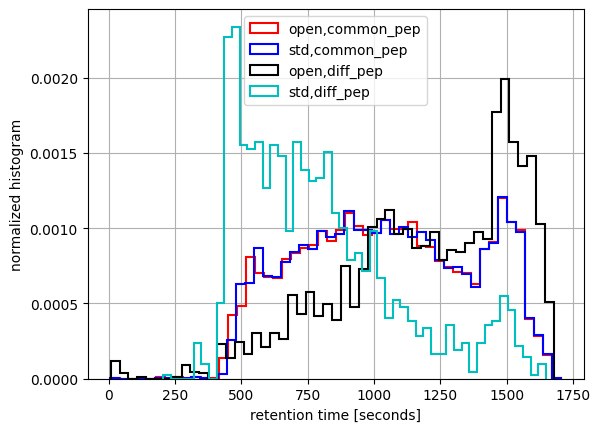

In [20]:
plt.xlabel('retention time [seconds]')
plt.ylabel('normalized histogram')

plt.hist(PepInCommon["rt_x"]*60, bins=50,histtype='step',density=True,linewidth=1.5,color='r',label='open,common_pep')
plt.hist(PepInCommon["rt_y"]*60, bins=50,histtype='step',density=True,linewidth=1.5,color='b',label='std,common_pep')
plt.hist(DiffInTable1["rt_x"]*60,bins=50,histtype='step',density=True,linewidth=1.5,color='k',label='open,diff_pep')
plt.hist(DiffInTable2["rt_x"]*60,bins=50,histtype='step',density=True,linewidth=1.5,color='c',label='std,diff_pep')

plt.grid()
plt.legend()
plt.show()

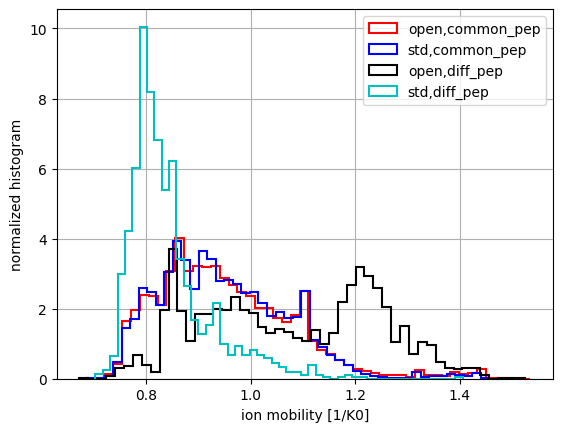

In [21]:
plt.xlabel('ion mobility [1/K0]')
plt.ylabel('normalized histogram')

plt.hist(PepInCommon["ion_mobility_x"], bins=50,histtype='step',density=True,linewidth=1.5,color='r',label='open,common_pep')
plt.hist(PepInCommon["ion_mobility_y"], bins=50,histtype='step',density=True,linewidth=1.5,color='b',label='std,common_pep')
plt.hist(DiffInTable1["ion_mobility_x"],bins=50,histtype='step',density=True,linewidth=1.5,color='k',label='open,diff_pep')
plt.hist(DiffInTable2["ion_mobility_x"],bins=50,histtype='step',density=True,linewidth=1.5,color='c',label='std,diff_pep')

plt.grid()
plt.legend()
plt.show()

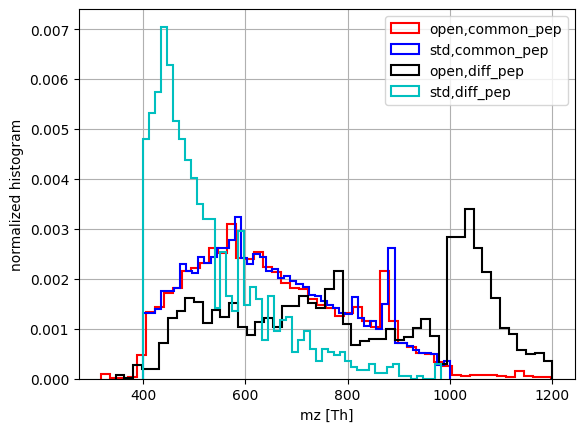

In [22]:
plt.xlabel('mz [Th]')
plt.ylabel('normalized histogram')

plt.hist(PepInCommon["mz_x"], bins=50,histtype='step',density=True,linewidth=1.5,color='r',label='open,common_pep')
plt.hist(PepInCommon["mz_y"], bins=50,histtype='step',density=True,linewidth=1.5,color='b',label='std,common_pep')
plt.hist(DiffInTable1["mz_x"],bins=50,histtype='step',density=True,linewidth=1.5,color='k',label='open,diff_pep')
plt.hist(DiffInTable2["mz_x"],bins=50,histtype='step',density=True,linewidth=1.5,color='c',label='std,diff_pep')

plt.grid()
plt.legend()
plt.show()

The common_pep results are shown as red and blue colors for the two datasets, while that of the diff_pep are shown as black and cyan colors.

We have noticed that:
* common_pep has very similar results for the two datasets as it should be
* clear difference is seen for diff_pep

To get a clearer impression of the difference, we also demonstrate the 2D plot of mz/retention time and mz/ion mobility in the following figures.

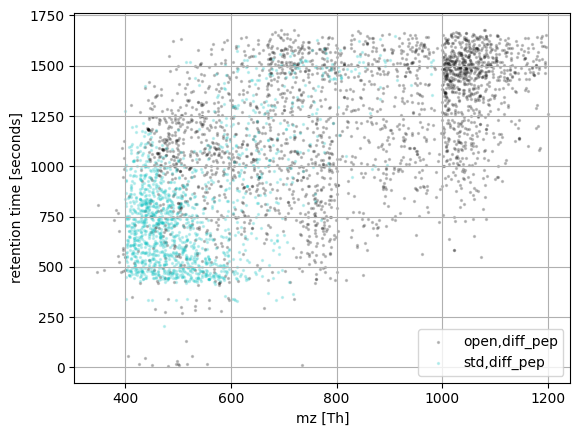

In [23]:
plt.xlabel('mz [Th]')
plt.ylabel('retention time [seconds]')

plt.scatter(DiffInTable1["mz_x"],DiffInTable1["rt_x"]*60,color='k',marker="o",s=2,alpha=.2,label='open,diff_pep')
plt.scatter(DiffInTable2["mz_x"],DiffInTable2["rt_x"]*60,color='c',marker="o",s=2,alpha=.2,label='std,diff_pep')

plt.grid()
plt.legend()
plt.show()

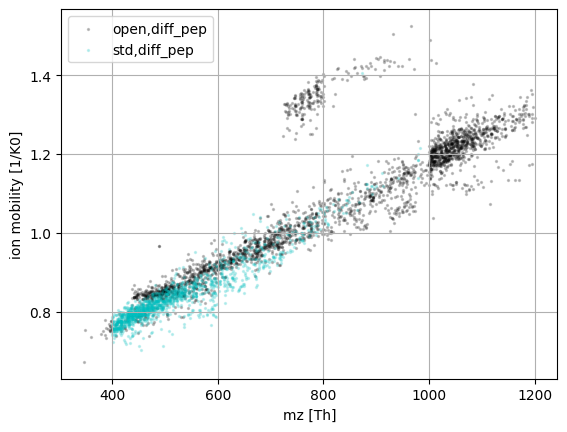

In [24]:
plt.xlabel('mz [Th]')
plt.ylabel('ion mobility [1/K0]')

plt.scatter(DiffInTable1["mz_x"],DiffInTable1["ion_mobility_x"],color='k',marker="o",s=2,alpha=.2,label='open,diff_pep')
plt.scatter(DiffInTable2["mz_x"],DiffInTable2["ion_mobility_x"],color='c',marker="o",s=2,alpha=.2,label='std,diff_pep')

plt.grid()
plt.legend()
plt.show()

Moreover, obvious difference for diff_pep is also seen in the plots of charge, peptide length and the MS1 intensity.

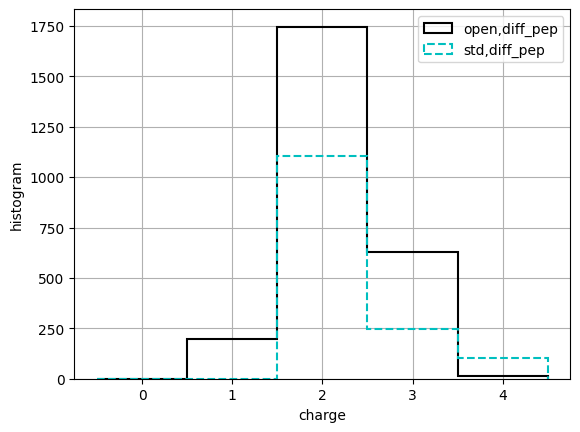

In [25]:
plt.xlabel('charge')
plt.ylabel('histogram')

x=DiffInTable1["charge_x"]
y=DiffInTable2["charge_x"]
plt.hist(x,bins=np.arange(0,x.max()+1.5)-0.5,histtype='step',linewidth=1.5,color='k',label='open,diff_pep')
plt.hist(y,bins=np.arange(0,y.max()+1.5)-0.5,histtype='step',linewidth=1.5,color='c',label='std,diff_pep',linestyle='dashed')

plt.grid()
plt.legend()
plt.show()

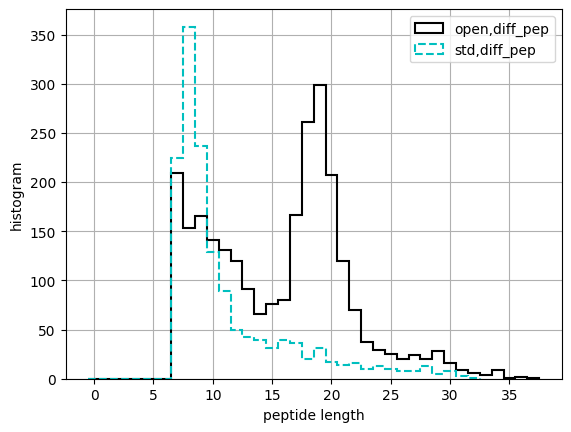

In [26]:
plt.xlabel('peptide length')
plt.ylabel('histogram')

x=DiffInTable1["stripped_peptides"].str.len()
y=DiffInTable2["stripped_peptides"].str.len()
plt.hist(x,bins=np.arange(0,x.max()+1.5)-0.5,histtype='step',linewidth=1.5,color='k',label='open,diff_pep')
plt.hist(y,bins=np.arange(0,y.max()+1.5)-0.5,histtype='step',linewidth=1.5,color='c',label='std,diff_pep',linestyle='dashed')

plt.grid()
plt.legend()
plt.show()

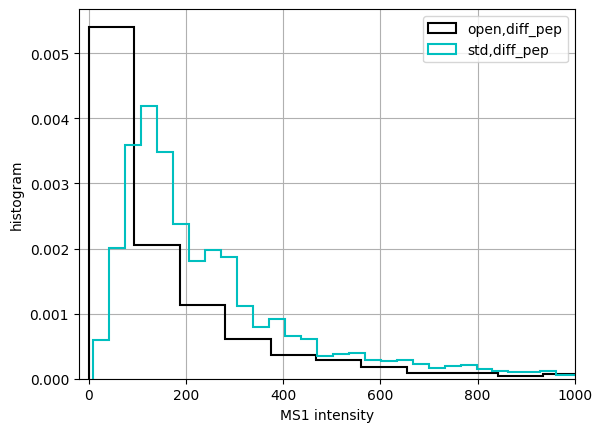

In [27]:
plt.xlabel('MS1 intensity')
plt.ylabel('histogram')

plt.xlim([-20,1000])
x=DiffInTable1["ms1_intensity_x"]
y=DiffInTable2["ms1_intensity_x"]
#plt.hist(x,bins=np.arange(0,x.max()+1.5)-0.5,histtype='step',linewidth=1.5,color='k',label='open,diff_pep')
#plt.hist(y,bins=np.arange(0,y.max()+1.5)-0.5,histtype='step',linewidth=1.5,color='c',label='std,diff_pep',linestyle='dashed')
plt.hist(x,bins=200,histtype='step',density=True,linewidth=1.5,color='k',label='open,diff_pep')
plt.hist(y,bins=200,histtype='step',density=True,linewidth=1.5,color='c',label='std,diff_pep')

plt.grid()
plt.legend()
plt.show()

In [29]:
todays_date = str(datetime.now().date())
print(f"Author: Yani Zhao\nBruker\n{todays_date}")

Author: Yani Zhao
Bruker
2024-01-12
